#### Import packages

In [1]:
import georinex as gr
import numpy as np
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import xarray as xr
import scipy.stats as sc
import pandas as pd

### RINEX 3 version
#### Load RINEX 3 files

In [2]:
### RINEX 3: 1 hour window
obs = gr.load('test_data/Rinex3/KLSQ00GRL_R_20213070000_01D_15S_MO.rnx', tlim=['2021-11-03T11:32', '2021-11-03T12:32'])

#### Functions used for calculating MP1 and MP2 (GPS)

In [3]:
# Functions

def calculate_MP1_G(obs, sv, freq):
    
    ### Calculate code multipath for first frequency, for GPS

    # Inputs:
    # obs: the loaded observation file
    # sv: chosen satellite vehicle
    # freq: list of frequencies for GPS
    
    # Output:
    # MP1 value

    c= 299792458;
    f1 = freq[0]*1e6
    f2 = freq[1]*1e6
    obs = obs.sel(sv=sv).dropna(dim='time',how='all')

    P1 = obs.C1C
    L1 = obs.L1C*c/f1
    L2 = obs.L2W*c/f2

    MP = P1 - (f1**2 + f2**2)/(f1**2 - f2**2)*L1 + (2*(f2**2))/(f1**2 - f2**2)*L2;
    
    # Ambiguities
    navg = np.sum(MP)/len(MP)
    MP = MP - navg

    return MP
 
def append_MP_arrays(sv, obs, freq):
    
    ### Function for appending results from 'calculate_MP1_G' function.
    ### Used when we want MP results for many satellites in one variable.
    
    # Inputs:
    # sv: a list of GPS satellites that appear in the loaded RINEX file
    # obs: the loaded observation file
    # freq: list of frequencies for GPS
    
    # Output:
    # An array of appended MP values for many satellites which makes it easy to store/plot results
    
    MP = []
    for i in range(0, len(sv)):
        MP.append(calculate_MP1_G(obs, sv[i], freq))
    return MP

def plot_all_MP(sv,MP):
    
    ### Use the result of 'append_MP_arrays' function to plot multipath.
    
    # Inputs:
    # sv: a list of GPS satellites that appear in the loaded RINEX file
    # MP: output from the 'append_MP_arrays' function
    
    # Output:
    # No output, the function uses the command 'ax.plot()' as many times as there are satellites
    
    for i in range(0,len(sv)):
        ax.plot(MP[i], label=sv[i])
        
def sort_sat_types(obs):
    
    ### Function that creates arrays for each satellite constellation type
    ### and then assigns satellites from the RINEX file to the corresponding arrays
    
    # Inputs:
    # obs: the loaded observation file
    
    # Outputs:
    # 7 lists of satellite numbers that were included in the loaded obs file
    # G-GPS, R-GLONASS, S-SBAS, E-Galileo, C-BeiDou, J-QZSS, I-IRNSS
    
    svG = []
    svR = []
    svS = []
    svE = []
    svC = []
    svJ = []
    svI = []
    
    # Assign values to distinguish 
    for i in range(0,len(obs.sv)):
        if str(obs.sv[i].values)[0]=='G':          svG.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='R':        svR.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='S':        svS.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='E':        svE.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='C':        svC.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='J':        svJ.append(str(obs.sv[i].values))
        elif str(obs.sv[i].values)[0]=='I':        svI.append(str(obs.sv[i].values))

    return svG, svR, svS, svE, svC, svJ, svI

def load_constellation_freq():
    
    ### Function that loads frequency variables for each constellation
    
    # Inputs: none
    # Outputs: constellation arrays
    
    GPS_freq = [1575.42, 1227.60, 1176.45] # L1, L2, L5 for GPS
    GLONASS_freq = [1603.6875, 1247.3125, 1202.025] # G1, G2, G3 for GLONASS
    Galileo_freq = [1575.42, 1278.75, 1191.795] # E1, E6, E5 for Galileo (no L2)
    SBAS_freq = [1575.42, 1176.45] # L1, L5 for SBAS
    QZSS_freq = [1575.42, 1227.60, 1176.45, 1278.75] # L1, L2, L5, L6 for QZSS
    BDS_freq = [1561.098, 1207.14, 1268.52] # B1, B2, B3 for BeiDou
    IRNSS_freq = [1176.45, 2492.028] # L5, S for IRNSS
    
    return GPS_freq, GLONASS_freq, Galileo_freq, SBAS_freq, QZSS_freq, BDS_freq, IRNSS_freq


#### Run functions to get MP values

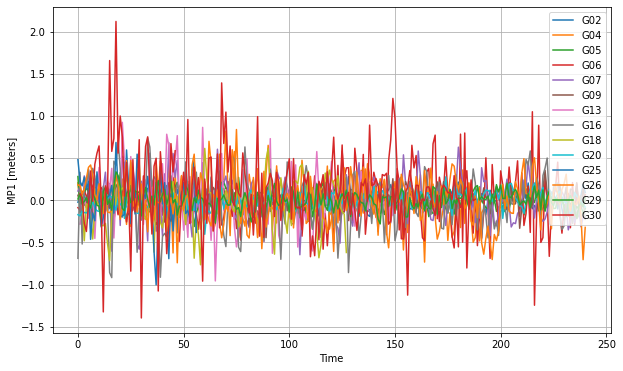

In [4]:
# Separate satellites from different constellations
svG, svR, svS, svE, svC, svJ, svI = sort_sat_types(obs)

# Load frequencies - index 0 for GPS
freq = load_constellation_freq()

# Calculate multipath and append arrays
MP_G = append_MP_arrays(svG, obs, freq[0])

# Plot results for different satellites
ax = figure(figsize=(10, 6)).gca()
plot_all_MP(svG, MP_G)
ax.grid()
ax.legend()
plt.xlabel('Time')
plt.ylabel('MP1 [meters]')
show()

### RINEX 2 version

In [5]:
### RINEX 2: full file
obs = gr.load("test_data/Rinex2/klsq3070.21o")

# Optionally, load smaller time window:
#obs = gr.load("Rinex2/Rinex2/klsq3070.21o", tlim=['2021-11-03T12:00:15', '2021-11-03T13:00:15'])

In [6]:
# FUNCTIONS RINEX 2 version

def calculate_MP1_G_rnx2(obs, sv, freq):
    
    ### Calculate code multipath for first frequency, for GPS

    # Inputs:
    # obs: the loaded observation file
    # sv: chosen satellite vehicle
    # freq: list of frequencies for GPS
    
    # Output:
    # MP1 value
    
    c= 299792458;
    f1 = freq[0]*1e6
    f2 = freq[1]*1e6
    obs = obs.sel(sv=sv).dropna(dim='time',how='all')
    
    P1 = obs.C1
    L1 = obs.L1*c/f1
    L2 = obs.L2*c/f2

    MP = P1 - (f1**2 + f2**2)/(f1**2 - f2**2)*L1 + (2*(f2**2))/(f1**2 - f2**2)*L2;
    
    # Ambiguities
    navg = np.sum(MP)/len(MP)
    MP = MP - navg

    return MP

def append_MP_arrays_rnx2(sv, obs, freq):
    
    ### Function for appending results from 'calculate_MP1_G_rnx2' functions.
    ### Used when we want MP results for many satellites in one variable.
    
    # Inputs:
    # sv: a list of GPS satellites that appear in the loaded RINEX file
    # obs: the loaded observation file
    # freq: list of frequencies for GPS
    
    # Output:
    # An array of appended MP values for many satellites which makes it easy to store/plot results
    
    MP = []
    for i in range(0, len(sv)):
        MP.append(calculate_MP1_G_rnx2(obs, sv[i], freq))
    return MP

#### Run functions to get MP values

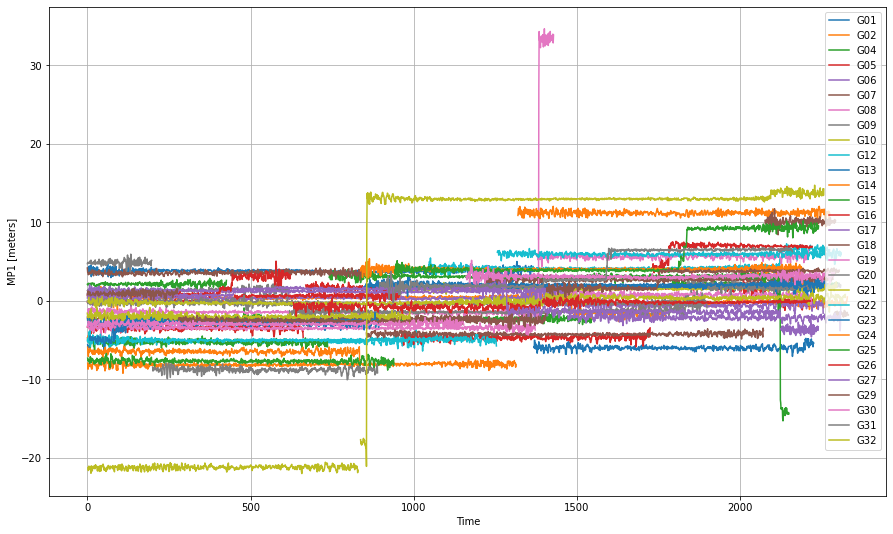

In [7]:
# Separate satellites from different constellations
svG, svR, svS, svE, svC, svJ, svI = sort_sat_types(obs)

# Load frequencies - index 0 for GPS
freq = load_constellation_freq()

# Calculate multipath and append arrays
MP_G = append_MP_arrays_rnx2(svG, obs, freq[0])

# Plot results for different satellites
ax = figure(figsize=(15, 9)).gca()
plot_all_MP(svG, MP_G)
ax.grid()
ax.legend()
plt.xlabel('Time')
plt.ylabel('MP1 [meters]')
show()